# Make Predictions

In [ ]:
# Set import path for local modules
import sys
import os
sys.path.append(os.path.abspath('..'))

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf

from src.data import load_data

TODOs
- Try CV with different sequence lengths: TSCV (sklearn or skforecast)
- Try MAPE and MASE as metrics
- Conformal Predictions 

In [4]:
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "TSLA"
start_date = "2015-01-01"
train_dataset, val_dataset, test_dataset = load_data(
    ticker,
    feature_cols,
    "RealisedVolatility",
    seq_len=30,
    start_date=start_date,
    train_size=0.6,
    test_size=0.2,
)

[*********************100%***********************]  1 of 1 completed


In [5]:
# Print shapes of the datasets
print(f"Train shape: {len(train_dataset)}")
print(f"\t Train X shape: {train_dataset.X.shape}")
print(f"\t Train y shape: {train_dataset.y.shape}")
print(f"\t Train dates shape: {train_dataset.dates.shape}")
print(f"Validation shape: {len(val_dataset) if val_dataset else 0}")
print(f"Test shape: {len(test_dataset)}")

Train shape: 1616
	 Train X shape: torch.Size([1616, 30, 8])
	 Train y shape: torch.Size([1616, 1])
	 Train dates shape: (1616,)
Validation shape: 539
Test shape: 539


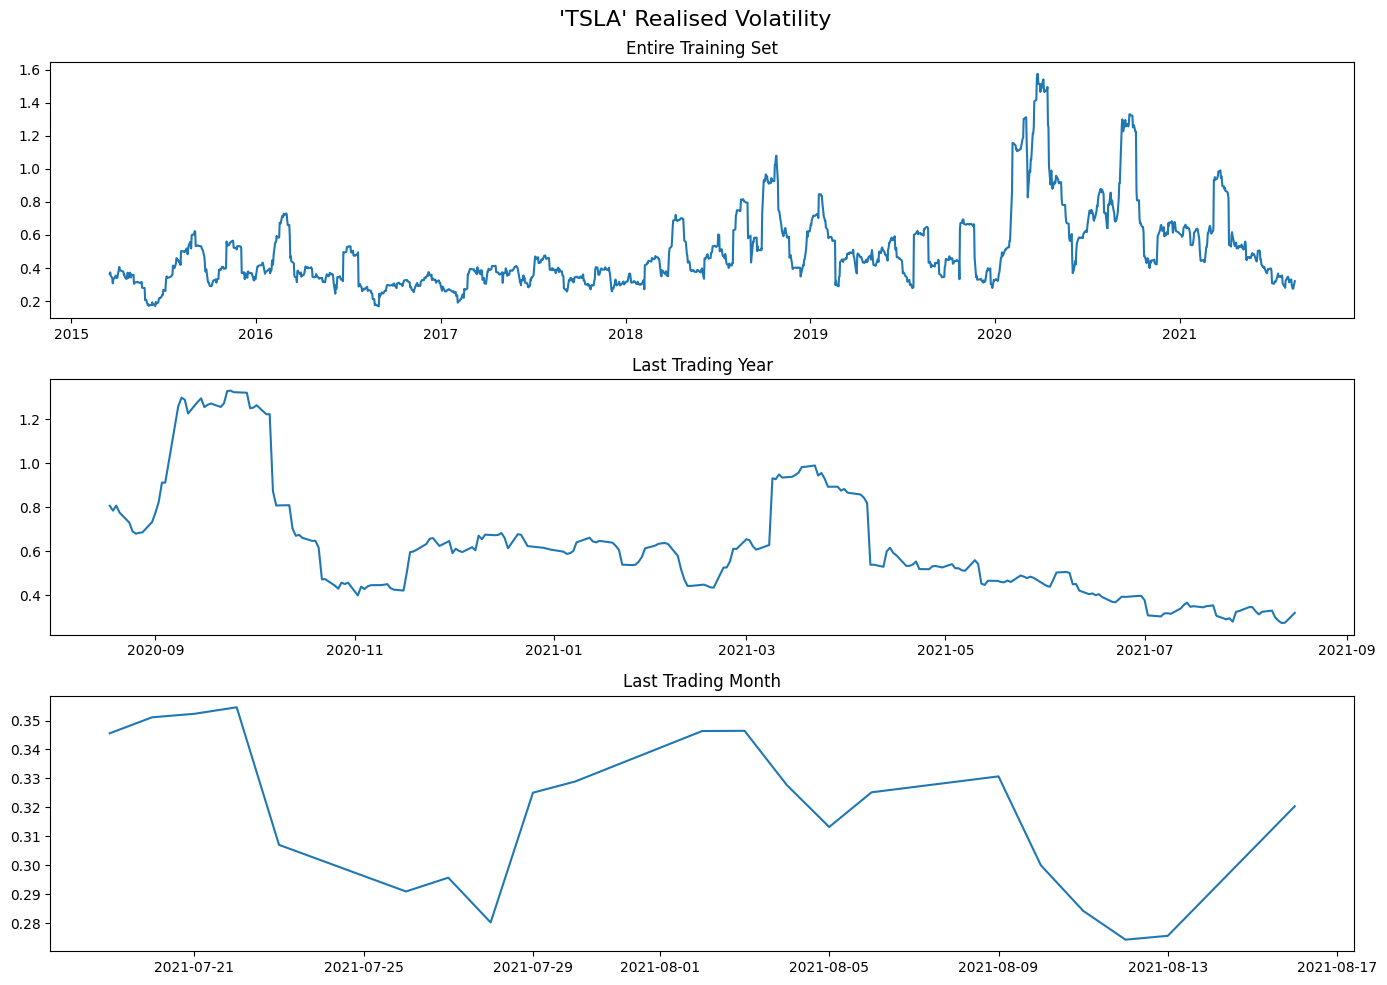

In [6]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Title for the entire figure
fig.suptitle(f'\'{ticker}\' Realised Volatility', fontsize=16)
# Plot entire training set
ax[0].plot(train_dataset.dates, train_dataset.y, label='Realised Volatility')
ax[0].set_title('Entire Training Set')
# Zoom into last trading year (last available in training set)
ax[1].plot(train_dataset.dates[-251:], train_dataset.y[-251:], label='Realised Volatility')
ax[1].set_title('Last Trading Year')
# Zoom into last month
ax[2].plot(train_dataset.dates[-21:], train_dataset.y[-21:], label='Realised Volatility')
ax[2].set_title('Last Trading Month')
plt.tight_layout()
plt.show()

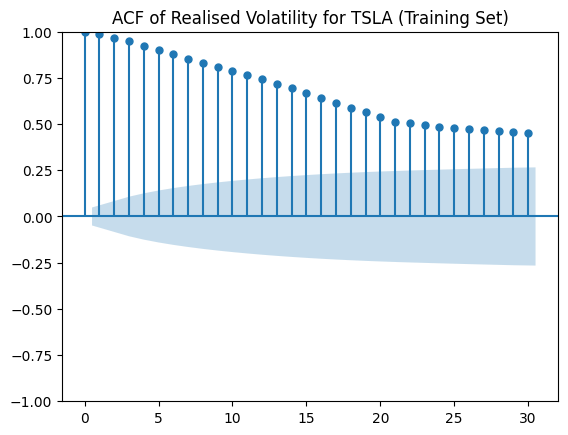

In [7]:
# Plot ACF of the target variable in the training set
plot_acf(train_dataset.y, lags=30)
plt.title(f'ACF of Realised Volatility for {ticker} (Training Set)')
plt.show()

## 2. Make Predictions
### 2.1 Base Model - Previous value

In [8]:
y_train = train_dataset.y
y_test  = test_dataset.y

# naive: y_pred[t] = y[t-1]
base_preds = np.empty_like(y_test)

# first test prediction = last training value
base_preds[0] = y_train[-1]

# the rest use previous test values
base_preds[1:] = y_test[:-1]

base_mae = mean_absolute_error(y_test, base_preds)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))

print(f"Naive Baseline:")
print(f"\t'Test' MAE:  {base_mae:.6f}")
print(f"\t'Test' RMSE: {base_rmse:.6f}")

Naive Baseline:
	'Test' MAE:  0.022133
	'Test' RMSE: 0.047037


Such low values of MAE and RMSE might seem surprising, but if we look at the autocorrelation coefficient of the 1st lag below (also seen in the ACF plot), we can see that there is a very high correlation (0.99) between the current value and the previous value. This means that using the previous value as a prediction is quite effective in this case.

In [9]:
print(f"Autocorrelation Coefficient for lag 1 = {pd.Series(y_train.ravel()).autocorr(lag=1):.4f}")

Autocorrelation Coefficient for lag 1 = 0.9853


### 2.2 Random Forest Regressor

Random Forest Regressor:
	Train MAE:  0.008635
	Train RMSE: 0.015619
	Test MAE:   0.030499
	Test RMSE:  0.049567


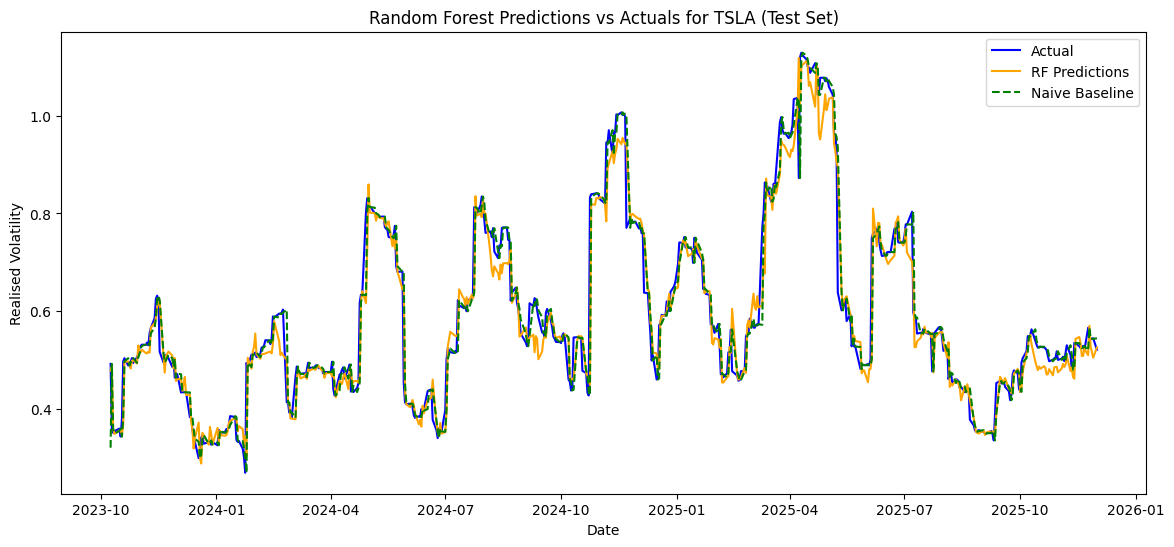

In [10]:
rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)


X_train_rf = train_dataset.X[:, -1, :]
X_val_rf = val_dataset.X[:, -1, :] if val_dataset else None
X_test_rf = test_dataset.X[:, -1, :]

rf.fit(X_train_rf, train_dataset.y.ravel())

# Predict
rf_train_preds = rf.predict(X_train_rf)
rf_val_preds = rf.predict(X_val_rf) if val_dataset else None
rf_test_preds = rf.predict(X_test_rf)

# Evaluate
rf_train_mae = mean_absolute_error(train_dataset.y, rf_train_preds)
rf_train_rmse = np.sqrt(mean_squared_error(train_dataset.y, rf_train_preds))

rf_test_mae = mean_absolute_error(test_dataset.y, rf_test_preds)
rf_test_rmse = np.sqrt(mean_squared_error(test_dataset.y, rf_test_preds))

print(f"Random Forest Regressor:")
print(f"\tTrain MAE:  {rf_train_mae:.6f}")
print(f"\tTrain RMSE: {rf_train_rmse:.6f}")
print(f"\tTest MAE:   {rf_test_mae:.6f}")
print(f"\tTest RMSE:  {rf_test_rmse:.6f}")

# Plot predictions vs actuals for the test set
plt.figure(figsize=(14, 6))
plt.plot(test_dataset.dates, test_dataset.y, label='Actual', color='blue')
plt.plot(test_dataset.dates, rf_test_preds, label='RF Predictions', color='orange')
plt.plot(test_dataset.dates, base_preds, label='Naive Baseline', color='green', linestyle='--')
plt.title(f'Random Forest Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 2.3 GARCH(1, 1)

GARCH(1, 1):
	Test MAE:   0.216254
	Test RMSE:  0.279649


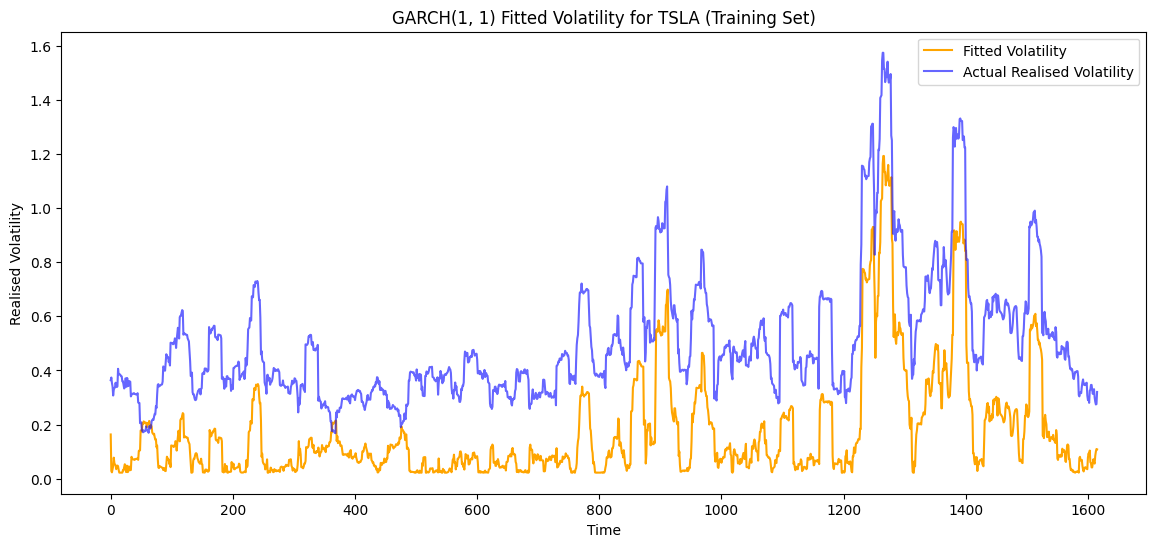

In [11]:
from arch import arch_model

# Fit GARCH(1, 1) model

garch_model = arch_model(train_dataset.y * 10, vol='Garch', p=1, q=1, mean='constant', dist='t')
# mean='constant' because in volatility forecasting we care about modeling the variance
# dist='t' because of fat tails in volatility forecasting (normal would underestimate
# extreme movements, often common in financial data)

garch_fitted = garch_model.fit(disp='off')
# print(garch_fitted.summary())

garch_forecast = garch_fitted.forecast(horizon=len(test_dataset))

garch_preds = garch_forecast.mean.iloc[-1].values
garch_preds /= 10  # scale back down

garch_mae = mean_absolute_error(test_dataset.y, garch_preds)
garch_rmse = np.sqrt(mean_squared_error(test_dataset.y, garch_preds))

print(f"GARCH(1, 1):")
print(f"\tTest MAE:   {garch_mae:.6f}")
print(f"\tTest RMSE:  {garch_rmse:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(garch_fitted.conditional_volatility / 10, label='Fitted Volatility', color='orange')
plt.plot(train_dataset.y, label='Actual Realised Volatility', color='blue', alpha=0.6)
plt.title(f'GARCH(1, 1) Fitted Volatility for {ticker} (Training Set)')
plt.xlabel('Time')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()

### 2.4 HAR-RV

In [12]:
rv = pd.Series(train_dataset.y.ravel(), index=train_dataset.dates)
rv_test = pd.Series(test_dataset.y.ravel(), index=test_dataset.dates)
full_rv = pd.concat([rv, rv_test])

# Daily Lag
full_rv_lag1 = full_rv.shift(1)

# Weekly Lag (5 trading days)
full_rv_lag5 = full_rv.rolling(window=5).mean().shift(1)

# Monthly Lag (21 trading days)
full_rv_lag21 = full_rv.rolling(window=21).mean().shift(1)

har_data = pd.DataFrame({
    'RV': full_rv,
    'RV_Lag1': full_rv_lag1,
    'RV_Lag5': full_rv_lag5,
    'RV_Lag21': full_rv_lag21,
}).dropna()

train_len = len(rv)  # index to split train/test
rows_dropped = len(full_rv) - len(har_data)  # rows dropped due to NaNs
split_point_in_har = train_len - rows_dropped  # adjust split index
har_train = har_data.iloc[:split_point_in_har]
har_test = har_data.iloc[split_point_in_har:]

In [13]:
import statsmodels.api as sm

X_train_har = har_train[["RV_Lag1", "RV_Lag5", "RV_Lag21"]]
y_train_har = har_train["RV"]

X_train_har = sm.add_constant(X_train_har)

har_model = sm.OLS(y_train_har, X_train_har).fit()

# print(har_model.summary())

In [14]:
X_test_har = har_test[["RV_Lag1", "RV_Lag5", "RV_Lag21"]]
X_test_har = sm.add_constant(X_test_har)

har_preds = har_model.predict(X_test_har)

HAR-RV Model:
	'Test' MAE:  0.022691
	'Test' RMSE: 0.046824


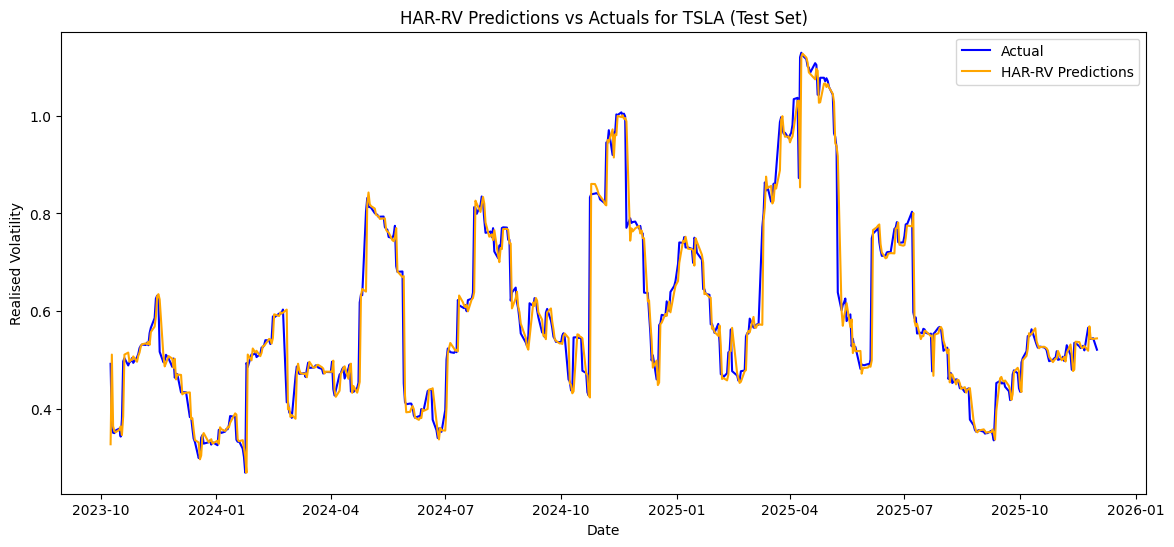

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

har_mae  = mean_absolute_error(har_test["RV"], har_preds)
har_rmse = np.sqrt(mean_squared_error(har_test["RV"], har_preds))

print(f"HAR-RV Model:")
print(f"\t'Test' MAE:  {har_mae:.6f}")
print(f"\t'Test' RMSE: {har_rmse:.6f}")

plt.figure(figsize=(14, 6))
plt.plot(har_test.index, har_test["RV"], label='Actual', color='blue')
plt.plot(har_test.index, har_preds, label='HAR-RV Predictions', color='orange')
plt.title(f'HAR-RV Predictions vs Actuals for {ticker} (Test Set)')
plt.xlabel('Date')
plt.ylabel('Realised Volatility')
plt.legend()
plt.show()


### 2.5 LSTM

In [16]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze()

In [17]:
from torch.utils.data import DataLoader
from src.data import TimeSeriesDataset

seq_len = 5
feature_cols = [
    "LogReturn",
    "RealisedVolatility",
    "RSI_14",
    "BB_Width",
    "MACD",
    "YZVolatility",
    "Log_CO",
    "Log_HL",
]
ticker = "AAPL"
start_date = "2015-01-01"
train_dataset, val_dataset, test_dataset = load_data(
    ticker,
    feature_cols,
    "RealisedVolatility",
    seq_len=seq_len,
    start_date=start_date,
    train_size=0.6,
    test_size=0.2,
)

batch_size = 32
train_ds = TimeSeriesDataset(train_dataset.X, train_dataset.y)
val_ds = TimeSeriesDataset(val_dataset.X, val_dataset.y) if val_dataset else None
test_ds = TimeSeriesDataset(test_dataset.X, test_dataset.y)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) if val_ds else None
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

[*********************100%***********************]  1 of 1 completed


In [18]:
from src.lstm_trainer import train_lstm, evaluate_lstm

model = LSTMRegressor(input_size=len(feature_cols))

model_name = "best_lstm_model.pth"
metrics = train_lstm(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,
    lr=1e-3,
    model_name=model_name
)
train_loss_history, train_rmse_history, val_loss_history, val_rmse_history, val_mase_history = metrics

model.load_state_dict(torch.load(f"../models/{model_name}"))
preds, lstm_test_mae, lstm_test_rmse = evaluate_lstm(model, test_loader, test_dataset.y)

print(f"LSTM Regressor Test MAE:  {lstm_test_mae:.6f}")
print(f"LSTM Regressor Test RMSE: {lstm_test_rmse:.6f}")

Epoch 10/100 | Train RMSE: 0.041609 | Val RMSE: 0.061981
Epoch 20/100 | Train RMSE: 0.035176 | Val RMSE: 0.042306
Epoch 30/100 | Train RMSE: 0.032204 | Val RMSE: 0.026665
Epoch 40/100 | Train RMSE: 0.027628 | Val RMSE: 0.025455
Epoch 50/100 | Train RMSE: 0.025996 | Val RMSE: 0.025576
Epoch 60/100 | Train RMSE: 0.027223 | Val RMSE: 0.026349
Epoch 70/100 | Train RMSE: 0.023528 | Val RMSE: 0.030818
Epoch 80/100 | Train RMSE: 0.024464 | Val RMSE: 0.033117
Epoch 90/100 | Train RMSE: 0.024071 | Val RMSE: 0.034237
Epoch 100/100 | Train RMSE: 0.023515 | Val RMSE: 0.039674

Best model saved to ../models/best_lstm_model.pth with Val RMSE: 0.022677
LSTM Regressor Test MAE:  0.018397
LSTM Regressor Test RMSE: 0.030899


I tried using MASE (Mean Absolute Scaled Error) as an additional evaluation metric for the LSTM model. However, as volatility differences can be quite small, the MASE values turned out to be very large and not very informative in this context. 

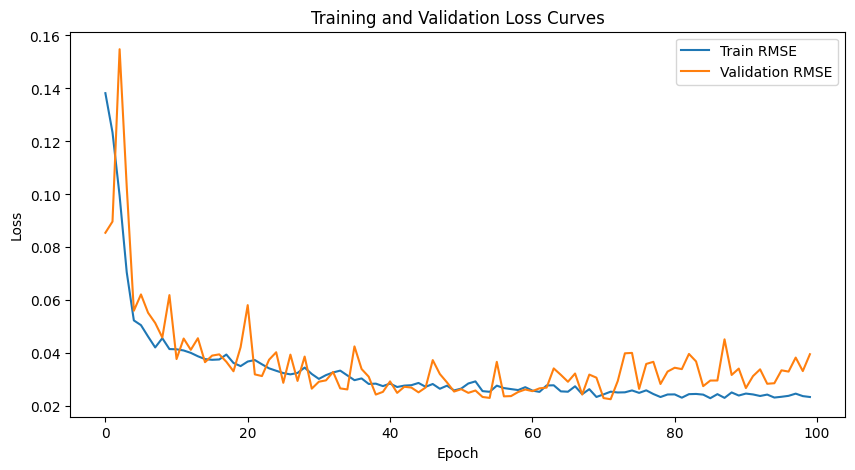

In [19]:
# Plot train and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

### 3. Metrics Comparison

In [24]:
import pandas as pd
def relative_mase(base_mae, model_mae):
    """
    'Relative Mase' here is defined as the ratio of model MAE to baseline MAE.
    """
    return model_mae / base_mae
# Summarize results in a DataFrame
results = pd.DataFrame({
    'Model': ['Naive Baseline', 'Random Forest', 'GARCH(1,1)', 'HAR-RV', 'LSTM Regressor'],
    'Test MAE': [base_mae, rf_test_mae, garch_mae, har_mae, lstm_test_mae],
    'Test RMSE': [base_rmse, rf_test_rmse, garch_rmse, har_rmse, lstm_test_rmse],
    '"Relative MASE"': [0, rf_test_mae / base_mae, garch_mae / base_mae, har_mae / base_mae, lstm_test_mae / base_mae],
})
print("Note: 'Relative MASE' is calculated as Model MAE / Baseline MAE. Therefore:",
      "\n\t- A value < 1 indicates better performance than the baseline.",
      "\n\t- A value > 1 indicates worse performance than the baseline.\n")
results

Note: 'Relative MASE' is calculated as Model MAE / Baseline MAE. Therefore: 
	- A value < 1 indicates better performance than the baseline. 
	- A value > 1 indicates worse performance than the baseline.



,Model,Test MAE,Test RMSE,"""Relative MASE"""
0,Naive Baseline,0.022133,0.047037,0.000000
1,Random Forest,0.030499,0.049567,1.377970
2,"GARCH(1,1)",0.216254,0.279649,9.770624
3,HAR-RV,0.022691,0.046824,1.025211
4,LSTM Regressor,0.018397,0.030899,0.831215
